# Overview
The default setup downloads and decompresses the model 
```bash
curl -L "https://www.dropbox.com/s/dlmpr7wabehq3x0/models.zip?dl=1" > models.zip
unzip models.zip
```

In [1]:
import os
import sys
sys.path.append('../')

In [2]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.utils as utils
import argparse
import time
import numpy as np
import cv2
from PIL import Image, ImageOps
from photo_wct import PhotoWCT, TORCH_MODE, get_dev_vec
from photo_smooth import Propagator

In [3]:
from collections import namedtuple
# prepare paths for model
vgg_paths = {}
for i in range(1,6):
    vgg_paths['vgg{}'.format(i)] = '../models/vgg_normalised_conv{}_1_mask.t7'.format(i) 
    vgg_paths['decoder{}'.format(i)] = '../models/feature_invertor_conv{}_1_mask.t7'.format(i)

vgg_key_list = list(vgg_paths.keys())
vgg_arg_class = namedtuple('VggArgs', vgg_key_list)
vgg_args = vgg_arg_class(*[vgg_paths[k] for k in vgg_key_list])

In [4]:
# Load model
p_wct = PhotoWCT(vgg_args)
p_pro = Propagator()

# Style and Content Images
He we load and show the style and content images

In [5]:
content_image_path = "../images/content1.png"
content_seg_path = []
style_image_path = "../images/style/in90.png"
style_seg_path = []
output_image_path = "../results/example1.png"

In [6]:
%matplotlib inline

get_dev_vec(p_wct)

# Load image
cont_img = Image.open(content_image_path).convert('RGB')
styl_img = Image.open(style_image_path).convert('RGB')
try:
    cont_seg = Image.open(content_seg_path)
    styl_seg = Image.open(style_seg_path)
except:
    cont_seg = []
    styl_seg = []
# equalize to make it spicier
# styl_img = ImageOps.equalize(styl_img)
# autocontrast to make it a bit brighter
# styl_img = ImageOps.autocontrast(styl_img)
# downsample to make it faster
cont_img = cont_img.resize((256, 256), Image.BICUBIC)
styl_img = styl_img.resize((256, 256), Image.BICUBIC)

Text(0.5,1,u'Style')

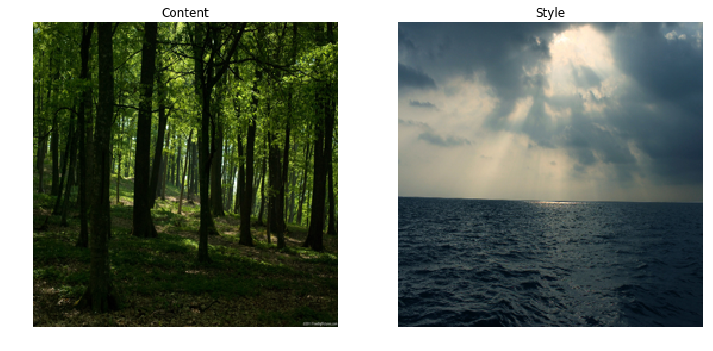

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(cont_img)
ax1.axis('off')
ax1.set_title('Content')
ax2.imshow(styl_img)
ax2.axis('off')
ax2.set_title('Style')

In [8]:
cont_img = transforms.ToTensor()(cont_img).unsqueeze(0)
styl_img = transforms.ToTensor()(styl_img).unsqueeze(0)
cont_img = Variable(get_dev_vec(cont_img), volatile=True)
styl_img = Variable(get_dev_vec(styl_img), volatile=True)

# Evaluate Model

In [9]:
cont_seg = np.asarray(cont_seg)
styl_seg = np.asarray(styl_seg)

start_style_time = time.time()
stylized_img = p_wct.transform(cont_img, styl_img, cont_seg, styl_seg)
end_style_time = time.time()
print('Elapsed time in stylization: %f' % (end_style_time - start_style_time))
utils.save_image(stylized_img.data.cpu().float(), output_image_path, nrow=1)

Elapsed time in stylization: 9.552531


In [10]:
start_propagation_time = time.time()
out_img = p_pro.process(output_image_path, content_image_path)
end_propagation_time = time.time()
print('Elapsed time in propagation: %f' % (end_propagation_time - start_propagation_time))
cv2.imwrite(output_image_path, out_img)

Elapsed time in propagation: 3.064283


True

In [11]:
if TORCH_MODE=='GPU':
    from smooth_filter import smooth_filter
    # smooth filter requires cuda
    start_postprocessing_time = time.time()
    out_img = smooth_filter(output_image_path, content_image_path, f_radius=15, f_edge=1e-1)
    end_postprocessing_time = time.time()
    print('Elapsed time in post processing: %f' % (end_postprocessing_time - start_postprocessing_time))
else:
    print('Skipping Smoothing')
    # switching BGR to RGB
    out_img = Image.fromarray(np.array(out_img)[:,:,::-1])
out_img.save(output_image_path)

Skipping Smoothing


Text(0.5,1,u'Style Transfered')

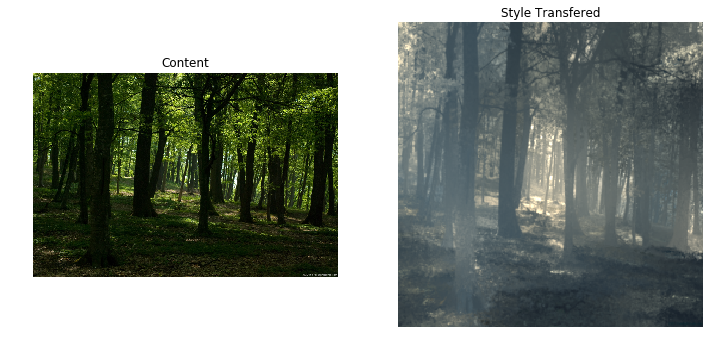

In [12]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(Image.open(content_image_path))
ax1.axis('off')
ax1.set_title('Content')
ax2.imshow(out_img)
ax2.axis('off')
ax2.set_title('Style Transfered')